In [1]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


Using TensorFlow backend.


In [2]:
# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
batch_size = 128
num_classes = 10
epochs = 50


In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [62]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [63]:
x_train = np.reshape(np.array(x_train), (60000, 784))
x_test = np.reshape(np.array(x_test), (10000, 784))
x_train = x_train / 255
x_test = x_test / 255

In [64]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [65]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [10]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim)) 
    model.add(Activation('softmax'))
    return model

# def k_model(output_dim,input_dim):
#     model = Sequential() 
#     model.add(Dense(1000, input_dim=input_dim))
#     model.add(Activation('relu'))
#     model.add(Dense(output_dim))
#     model.add(Activation('softmax'))
#     return model

In [11]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [12]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

### Baseline model 
Got one layer that maps input to 10 classes






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/50




60000/60000 [==============================] - 4s 69us/step - loss: 1.2528 - acc: 0.7102 - val_loss: 0.8072 - val_acc: 0.8295
Epoch 2/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.7130 - acc: 0.8406 - val_loss: 0.6069 - val_acc: 0.8603
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.5864 - acc: 0.8594 - val_loss: 0.5256 - val_acc: 0.8709
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.5253 - acc: 0.8684 - val_loss: 0.4804 - val_acc: 0.8788
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.4879 - acc: 0.8752 - val_loss: 0.4507 - val_acc: 0.8842
Epoch 6/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.4621 - acc: 0.8797 - val_loss: 0.4293 - val_acc: 0.8885
Epoch 7/50
60000/60000 

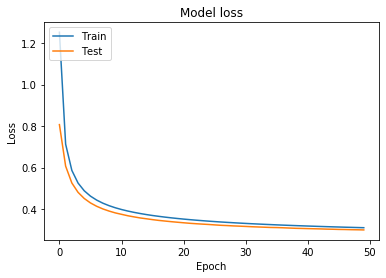

In [13]:
base_model=k_model(10,784)

#base_model=k_model(10,784)
base_model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False),metrics=['accuracy'])
base_model = base_model.fit(x_train, y_train,
              batch_size=128,
              epochs=50,
              verbose=1,
              validation_data=(x_test, y_test))
        
loss(base_model)

## The baseline model gives an accuracy of 91.36% at the end of 50 epochs

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [14]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [15]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [1]:
def local_sgd(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(k_model(10,784))
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
      
    
    # Training and averaging the weights
    num_epoch = 0 # keeps track of number of epochs
    itr = 0 # keeps track of number of iterations
    c = 0 #keeps track of batch number of the data to process
    
    while (num_epoch != epoch):
        while (True):
            for k in range(n):
                batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                models[k].train_on_batch(batch_x, batch_y)

            c += 1
            itr += 1
            c = c % num_batch

            if (itr % t == 0):
                weights = []
                for l in range(n):
                    weights.append(models[l].get_weights())
                    

                new_weight = weights[0]
                
                # Averaging the weights and assigning it to each model on the nodes
                for l in range(1,n):
                        new_weight = np.array(new_weight) + np.array(weights[l])

         
                for l in range(n):
                    models[l].set_weights(list(np.array(new_weight)/n))
                    
                
                
            if (c == 0):
    
                num_epoch += 1
                loss_tr = models[0].evaluate(train_data[0],train_data[1])
                loss_te = models[0].evaluate(test_data[0],test_data[1])
                print ("Epoch " + str(num_epoch) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
                train_loss.append(loss_tr[0])
                test_loss.append(loss_te[0])
                
                break
    
    
    return (train_loss,test_loss)

In [17]:
model_parallel = k_model(10,784)
#local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))
local_8_5000_01 = local_sgd(model_parallel,8,5000,0.01,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 0s 38us/step
Epoch 1 of 50 : train loss - 0.8423559758504232 : train accuracy - 0.8211666666666667 test loss - 0.8168074135780334 test accuracy - 0.8324
10000/10000 [==============================] - 0s 37us/step
Epoch 2 of 50 : train loss - 0.6360716505845387 : train accuracy - 0.8511 test loss - 0.6103917025566101 test accuracy - 0.8635
10000/10000 [==============================] - 0s 34us/step
Epoch 3 of 50 : train loss - 0.5524379695653916 : train accuracy - 0.8644666666666667 test loss - 0.5276010418176651 test accuracy - 0.874
10000/10000 [==============================] - 0s 35us/step
Epoch 4 of 50 : train loss - 0.505361772608757 : train accuracy - 0.8717333333333334 test loss - 0.4813627912044525 test accuracy - 0.8804
10000/10000 [==============================] - 0s 36us/step
Epoch 5 of 50 : train loss - 0.47445140011310577 : train accuracy - 0.8766666666666667 test loss - 0.45120533010959624 test accuracy - 0.8859
10000/10000 

### The below 4 cells runs the local SGD model for 2,4,8,16 number of nodes and tunes the learning rate by taking 4 different values for each

In [18]:

model_parallel = k_model(10,784)
local_2_10_001 = local_sgd(model_parallel,2,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_01 = local_sgd(model_parallel,2,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_05 = local_sgd(model_parallel,2,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_2_10_1 = local_sgd(model_parallel,2,10,0.1,50,128,(x_train,y_train),(x_test,y_test))



10000/10000 [==============================] - 0s 36us/step
Epoch 1 of 50 : train loss - 1.907777407646179 : train accuracy - 0.5418 test loss - 1.898582092666626 test accuracy - 0.5465
10000/10000 [==============================] - 0s 35us/step
Epoch 2 of 50 : train loss - 1.6054866991678873 : train accuracy - 0.6909166666666666 test loss - 1.5901752113342285 test accuracy - 0.6992
10000/10000 [==============================] - 0s 37us/step
Epoch 3 of 50 : train loss - 1.392701829401652 : train accuracy - 0.74505 test loss - 1.37341535320282 test accuracy - 0.7553
10000/10000 [==============================] - 0s 36us/step
Epoch 4 of 50 : train loss - 1.2394732522010803 : train accuracy - 0.7733833333333333 test loss - 1.2176364192962645 test accuracy - 0.7823
10000/10000 [==============================] - 0s 36us/step
Epoch 5 of 50 : train loss - 1.1255818398793538 : train accuracy - 0.7905833333333333 test loss - 1.1021168544769286 test accuracy - 0.8008
10000/10000 [===============

In [ ]:
model_parallel = k_model(10,784)
local_4_10_001 = local_sgd(model_parallel,4,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_01 = local_sgd(model_parallel,4,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_05 = local_sgd(model_parallel,4,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_4_10_1 = local_sgd(model_parallel,4,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

10000/10000 [==============================] - 0s 41us/step
Epoch 1 of 50 : train loss - 1.9442998500823974 : train accuracy - 0.5839833333333333 test loss - 1.9423519523620605 test accuracy - 0.5824
10000/10000 [==============================] - 0s 41us/step
Epoch 2 of 50 : train loss - 1.6302704312006633 : train accuracy - 0.7334166666666667 test loss - 1.6210623880386352 test accuracy - 0.7405
10000/10000 [==============================] - 0s 40us/step
Epoch 3 of 50 : train loss - 1.408235874112447 : train accuracy - 0.7746333333333333 test loss - 1.3941273082733154 test accuracy - 0.7812
10000/10000 [==============================] - 0s 44us/step
Epoch 4 of 50 : train loss - 1.2483653389930724 : train accuracy - 0.79585 test loss - 1.2309865188598632 test accuracy - 0.8033
10000/10000 [==============================] - 0s 41us/step
Epoch 5 of 50 : train loss - 1.130018494606018 : train accuracy - 0.8094 test loss - 1.110449498653412 test accuracy - 0.818
10000/10000 [==============

In [ ]:
model_parallel = k_model(10,784)
local_8_10_001 = local_sgd(model_parallel,8,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_01 = local_sgd(model_parallel,8,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_05 = local_sgd(model_parallel,8,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_10_1 = local_sgd(model_parallel,8,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
model_parallel = k_model(10,784)
local_16_10_001 = local_sgd(model_parallel,16,10,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_01 = local_sgd(model_parallel,16,10,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_05 = local_sgd(model_parallel,16,10,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_16_10_1 = local_sgd(model_parallel,16,10,0.1,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
# Function to show the loss plot of training and validation set
def combined_loss(losses,description):
    for i in losses :
        plt.plot(i[0])
        plt.title('Train loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()
    
    for i in losses :
        plt.plot(i[1])
        plt.title('Test loss')
        
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(description, loc='upper left')
    plt.show()

### Train test loss for node = 2

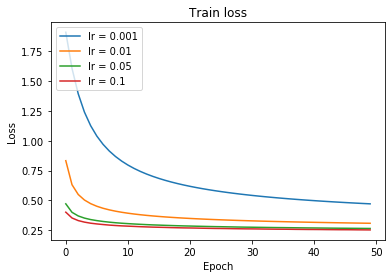

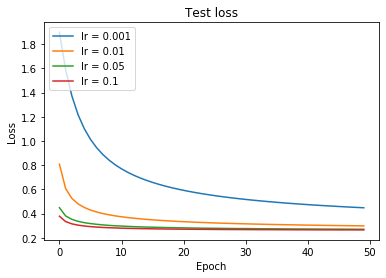

In [34]:
losses_2 = [local_2_10_001,local_2_10_01,local_2_10_05,local_2_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for node = 4

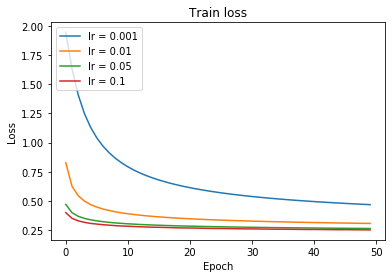

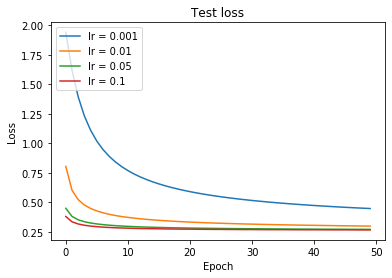

In [35]:
losses_2 = [local_4_10_001,local_4_10_01,local_4_10_05,local_4_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train Test loss for nodes = 8

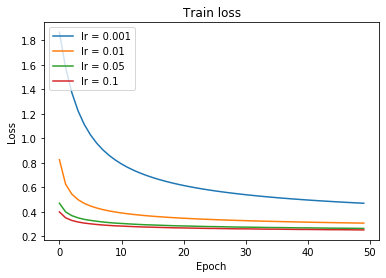

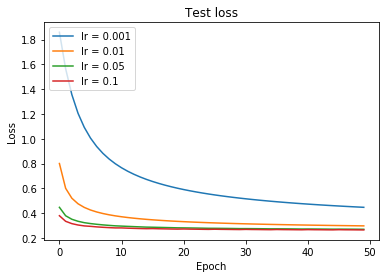

In [36]:
losses_2 = [local_8_10_001,local_8_10_01,local_8_10_05,local_8_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for nodes = 16

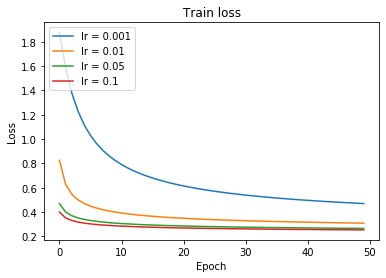

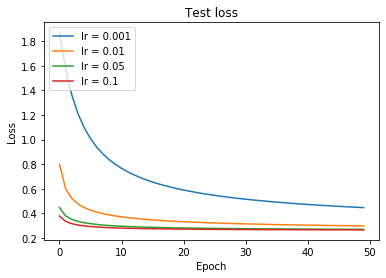

In [37]:
losses_2 = [local_16_10_001,local_16_10_01,local_16_10_05,local_16_10_1]
desc = ['lr = 0.001','lr = 0.01','lr = 0.05','lr = 0.1']
combined_loss(losses_2,desc)

### Train test loss for lr = 0.01 and nodes = 2,4,8,16

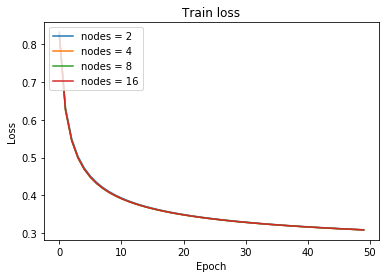

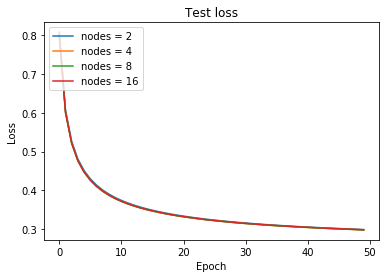

In [38]:
losses_2 = [local_2_10_01,local_4_10_01,local_8_10_01,local_16_10_01]
desc = ['nodes = 2','nodes = 4','nodes = 8','nodes = 16']
combined_loss(losses_2,desc)

In [2]:
local_2_10_01

NameError: name 'local_2_10_01' is not defined

### The convergence does not depend on number of nodes

In [ ]:
model_parallel = k_model(10,784)
local_8_16_01 = local_sgd(model_parallel,8,16,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_01 = local_sgd(model_parallel,8,8,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_01 = local_sgd(model_parallel,8,4,0.01,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_01 = local_sgd(model_parallel,8,2,0.01,50,128,(x_train,y_train),(x_test,y_test))

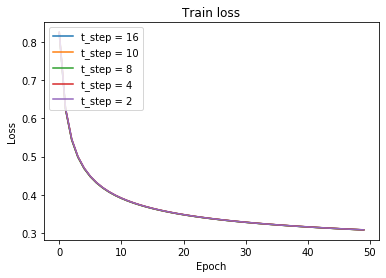

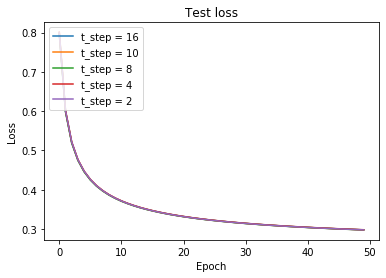

In [39]:
losses_time = [local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

### Convergence does not depend on averaging time step

In [ ]:
model_parallel = k_model(10,784)
#local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))
local_8_500_01 = local_sgd(model_parallel,8,500,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
model_parallel = k_model(10,784)
#local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))
local_8_1000_01 = local_sgd(model_parallel,8,1000,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
# One Shot Averaging : Minor tweaking in the previous function 

def local_sgd_oneshot_avg(model,n,t,alpha,epoch,batch_size,train_data,test_data): 
    '''
    This function performs local sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(model)
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
        
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        weights = []

        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break

            # Obtaining the weights from each model
            '''for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

            new_weight = weights[0]
            
            # Averaging the weights and assigning it to each model on the nodes
            for l in range(1,n):
                if l !=n-1:
                    new_layer=[j+k for j,k in zip(new_weight,weights[l])]
                else:
                    new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
            for l in range(len(models)):
                models[l].set_weights(new_weight)'''


        # Evalutaing the losses (train and test and appending it to the list)
        if (i != epoch - 1) :
            loss_tr = models[0].evaluate(train_data[0],train_data[1])
            loss_te = models[0].evaluate(test_data[0],test_data[1])
            print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
            train_loss.append(loss_tr[0])
            test_loss.append(loss_te[0])
            
    for l in range(len(models)):
        weights.append(models[l].layers[0].get_weights())
        new_weight = weights[0]
            
    # Averaging the weights and assigning it to each model on the nodes
    for l in range(1,n):
        if l !=n-1:
            new_weight = [j+k for j,k in zip(new_weight,weights[l])]
        else:
            new_weight = [(j+k)/n for j,k in zip(new_weight,weights[l])]
                    
    for l in range(len(models)):
            models[l].set_weights(new_weight)
            

    loss_tr = models[0].evaluate(train_data[0],train_data[1])
    loss_te = models[0].evaluate(test_data[0],test_data[1])
    print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
    train_loss.append(loss_tr[0])
    test_loss.append(loss_te[0])

    
    return (train_loss,test_loss)

In [ ]:
model_parallel = k_model(10,784)
local_oneshot_8_16_01 = local_sgd_oneshot_avg(model_parallel,8,16,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
# Tuning the learning rate for time steps = 2,4,8,16,100

# Time Step = 2
model_parallel = k_model(10,784)
local_8_2_001 = local_sgd(model_parallel,8,2,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_05 = local_sgd(model_parallel,8,2,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_1 = local_sgd(model_parallel,8,2,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_2_5 = local_sgd(model_parallel,8,2,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 4
model_parallel = k_model(10,784)
local_8_4_001 = local_sgd(model_parallel,8,4,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_05 = local_sgd(model_parallel,8,4,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_1 = local_sgd(model_parallel,8,4,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_4_5 = local_sgd(model_parallel,8,4,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 8
model_parallel = k_model(10,784)
local_8_8_001 = local_sgd(model_parallel,8,8,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_05 = local_sgd(model_parallel,8,8,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_1 = local_sgd(model_parallel,8,8,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_8_5 = local_sgd(model_parallel,8,8,0.5,50,128,(x_train,y_train),(x_test,y_test))

# Time Step = 16
model_parallel = k_model(10,784)
local_8_16_001 = local_sgd(model_parallel,8,16,0.001,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_05 = local_sgd(model_parallel,8,16,0.05,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_1 = local_sgd(model_parallel,8,16,0.1,50,128,(x_train,y_train),(x_test,y_test))
model_parallel = k_model(10,784)
local_8_16_5 = local_sgd(model_parallel,8,16,0.5,50,128,(x_train,y_train),(x_test,y_test))




In [3]:
# Plotting losses for t = 2
losses_8_t = [local_8_2_001,local_8_2_05,local_8_2_1,local_8_2_5,local_8_2_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_t,desc)

NameError: name 'local_8_2_001' is not defined

In [ ]:
# Plotting losses for t = 4
losses_8_4 = [local_8_4_001,local_8_4_05,local_8_4_1,local_8_4_5,local_8_4_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_4,desc)

In [ ]:
# Plotting losses for t = 8
losses_8_8 = [local_8_8_001,local_8_8_05,local_8_8_1,local_8_8_5,local_8_8_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_8,desc)

In [ ]:
# Plotting losses for t = 16
losses_8_16 = [local_8_16_001,local_8_16_05,local_8_16_1,local_8_16_5,local_8_16_01]
desc = ['lr = 0.001','lr = 0.05','lr = 0.1','lr = 0.5','lr = 0.01']
combined_loss(losses_8_16,desc)

In [ ]:

# Plotting the plots for different timesteps

losses_opt = [local_8_2_1,local_8_4_1,local_8_8_1,local_8_16_01,local_oneshot_8_16_01]
desc = ['time step = 2','time step = 4','time step = 8','time step = 16','one shot averaging']
combined_loss(losses_opt,desc)

In [ ]:
model_parallel = k_model(10,784)
local_8_100_01 = local_sgd(model_parallel,8,100,0.01,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
losses_time = [local_8_100_01,local_8_16_01,local_8_10_01,local_8_8_01,local_8_4_01,local_8_2_01]
desc = ['t_step = 100','t_step = 16','t_step = 10','t_step = 8','t_step = 4','t_step = 2']
combined_loss(losses_time,desc)

In [ ]:
def elastic_avg_sgd(input_dim,output_dim,n,t,alpha,rho,epoch,batch_size,train_data,test_data): 
    '''
    This function performs elastic averaging sgd. 
    
    Input :
       model : (keras model) The model that is to be placed on each node
       n : number of nodes
       epoch : the number of epochs
       batch_size : size of the batch for each iteration
       train_data : a tuple containing the training X and y
       test_data : a tuple containing the test X and y
       alpha : learning rate a float value
       rho : averaging step for the center variable
       
    Output:
       Returns a tuple containing Training and Test loss
    '''
    
    # Initialising the variables 
    c = 0
    train_loss = []
    test_loss = []
    model_data = []
    models = []
    
    # Preparing n sets of data by shuffling and creating a list models having n instances of model
    
    for i in range(n):
        model_data.append(shuffle(train_data[0],train_data[1]))
        models.append(k_model(output_dim,input_dim))
    
    # The model at the central node 
    central_model = k_model(output_dim,input_dim)
    central_model.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
    
    # Compiling all the models
    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False),
                    metrics=['accuracy'])
    
    
    # Calculating the center models
    # Taking the first center model as the average of all the weights from the individual models on the nodes
    weights = []
    for l in range(len(models)):
                weights.append(models[l].layers[0].get_weights())

    new_weight = weights[0]
            
    # Averaging the weights and assigning it to each model on the nodes
    for l in range(1,n):
        if l !=n-1:
            new_weight = [j+k for j,k in zip(new_weight,weights[l])]
        else:
            new_weight = [(j+k)/n for j,k in zip(new_weight,weights[l])]
    
    # Assigning the weights to the central model
    central_model.set_weights(new_weight)
            
    # At present the loop is designed to handle only one layer in the network. Will be modified to accomodate any number of layers
    for i in range(epoch):
        # This loop runs as long as the subsequent updates in c causes it to increase. c becomes 0 whenever the epoch completes
        while (True):
            c_prev = c
            
            # After every t iteration averaging the gradients
            for j in range(t):
                for k in range(len(models)):
                    batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]
                    batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]
                    models[k].train_on_batch(batch_x, batch_y)
                    
                c += 1
                c= c % num_batch
                
            if c_prev > c :
                break
            
            else :
                # Obtaining the weights from each model
                weights = []
                for l in range(len(models)):
                    weights.append(models[l].layers[0].get_weights())

                # Updating the weights of the models on every node using previous central node value
                central_weight = central_model.layers[0].get_weights()
                for l in range(0,n):
                    new_weight = list(np.array(weights[l]) - rho * (np.array(weights[l]) - np.array(central_weight)))
                    models[l].set_weights(new_weight)

                # Updating the weights on the central node
                delta = list(np.array(weights[0]) - np.array(central_weight))

                for l in range(1,n):
                    temp = list(np.array(weights[l]) - np.array(central_weight))
                    delta = list(np.array(delta) + np.array(temp))

                central_weight = list(np.array(central_weight) + rho * np.array(delta))
                central_model.layers[0].set_weights(central_weight)       
            


        # Evalutaing the losses (train and test and appending it to the list)
        loss_tr = central_model.evaluate(train_data[0],train_data[1])
        loss_te = central_model.evaluate(test_data[0],test_data[1])
        print ("Epoch " + str(i) + " of " + str(epoch) + " : train loss - " + str(loss_tr[0]) + " : train accuracy - " + str(loss_tr[1]) + " test loss - " + str(loss_te[0])+ " test accuracy - " + str(loss_te[1]))
        train_loss.append(loss_tr[0])
        test_loss.append(loss_te[0])
    
    return (train_loss,test_loss)

In [ ]:
elastic_2_10_001 = elastic_avg_sgd(784,10,2,10,0.01,0.1,50,128,(x_train,y_train),(x_test,y_test))

In [ ]:
1+1

In [ ]:
1+1

In [33]:
1

1